In [1]:
import numpy as np
import pandas as pd
from scipy import signal
from matplotlib import pyplot as plt
data = pd.read_csv('../data/train.csv')

In [2]:
data = np.array(data)
m, n = data.shape

np.random.shuffle(data) # Shuffles all the individual rows

data_dev = data[0:1000].T #Take the first 1000 rows, and transpose the matrix to get 1000 examples as column vectors
Y_dev = data_dev[0] #Takes the first row, which contains all of the answers to the numbers (the Y is what we want)
X_dev = data_dev[1:n]
X_dev = X_dev.reshape(28,28,1000)

data_train = data[2000:m].T
Y_train = data_train[0]
X_train= data_train[1:n] #Takes all of the data corresponding to all of the entries
X_train = X_train.reshape(28,28,-1)

data_test = data[1000:2000].T
Y_test = data_test[0]
X_test= data_test[1:n] #Takes all of the data corresponding to all of the entries
X_test = X_test.reshape(28,28,-1)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_dev.shape)
print(Y_dev.shape)

(28, 28, 40000)
(40000,)
(28, 28, 1000)
(1000,)
(28, 28, 1000)
(1000,)


In [3]:
def batch_norm_forward(x, gamma, beta, eps=1e-5):
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)
    x_normalized = (x - mean) / np.sqrt(variance + eps)
    out = gamma * x_normalized + beta
    cache = (x, x_normalized, mean, variance, gamma, beta, eps)
    return out, cache

def batch_norm_backward(dout, cache):
    x, x_normalized, mean, variance, gamma, beta, eps = cache
    N = x.shape[0]
    
    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout * x_normalized, axis=0)
    
    dx_normalized = dout * gamma
    dvariance = np.sum(dx_normalized * (x - mean) * -0.5 * np.power(variance + eps, -1.5), axis=0)
    dmean = np.sum(dx_normalized * -1 / np.sqrt(variance + eps), axis=0) + dvariance * np.sum(-2 * (x - mean), axis=0) / N
    
    dx = dx_normalized / np.sqrt(variance + eps) + dvariance * 2 * (x - mean) / N + dmean / N
    return dx, dgamma, dbeta


In [9]:
def max_pooling(input_data):
    # 24, 24, 2
    input_height, input_width, input_depth = input_data.shape

    # Calculate the output dimensions
    output_height = input_height // 2 # 12
    output_width = input_width // 2 # 12
    output_depth = input_depth # 2 - depth stays the same

    # Initialize the output array and array to store indices
    output_data = np.zeros((output_height, output_width, output_depth))
    indices = np.zeros((output_height, output_width, output_depth, 2), dtype=int)

    # Apply max pooling
    for h in range(output_height):
        for w in range(output_width):
            for d in range(output_depth):
                # Extract the 2x2 region of interest from the input data
                region = input_data[h*2:(h+1)*2, w*2:(w+1)*2, d]
                # Compute the maximum value in the region
                max_val = np.max(region)
                output_data[h, w, d] = max_val
                # Find the indices of the maximum value in the region
                max_indices = np.unravel_index(np.argmax(region), region.shape)
                # Store the indices relative to the region and convert to global indices
                indices[h, w, d] = [h*2 + max_indices[0], w*2 + max_indices[1]]

    return output_data, indices


In [4]:
def der_ReLU(Z):
  return Z > 0

def ReLU2(Z, alpha=0.01):
    return np.where(Z > 0, Z, alpha * Z)

def ReLU(Z): # Takes in a scalar, returns a scalar
    return np.maximum(Z, 0)

def ReLU2(Z): # Takes in a scalar, returns a scalar
    return np.maximum(Z, 0)

def sigmoid_prime(z):
  return sigmoid(z)*(1-sigmoid(z))

def sigmoid(z):
    # Compute the sigmoid function element-wise
    return 1.0 / (1.0 + np.exp(-z))

def softmax(Z):
    # Apply softmax column-wise
    exp_Z = np.exp(Z - np.max(Z, axis=0))  # Subtracting the maximum value in each column to avoid overflow
    return exp_Z / np.sum(exp_Z, axis=0)

In [5]:
import math

def params():
    layer_weights = np.random.randn(5, 5, 2) * np.sqrt(2. / 5)
    layer_bias = np.zeros((24, 24, 2))
    layer_output = np.zeros((24, 24, 2)) #(24, 24, 2)
    fc_weights = np.random.randn(10, 288) * np.sqrt(2. / 288)
    fc_bias = np.zeros((10, 1))
    gamma_conv = np.ones((24, 24, 2))
    beta_conv = np.zeros((24, 24, 2))
    gamma_fc = np.ones((10, 1))
    beta_fc = np.zeros((10, 1))
    return layer_weights, layer_bias, layer_output, fc_weights, fc_bias, gamma_conv, beta_conv, gamma_fc, beta_fc


def forward_propagation(layer_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias, gamma_conv, beta_conv, gamma_fc, beta_fc, dropout_rate=0.5):
    # Convolution
    for i in range(2): # 2 filters in total
        layer_output[:,:,i] = signal.correlate2d(layer_input, layer_weights[:,:,i], mode='valid')
    layer_output = layer_output + layer_bias   # (24, 24, 2)
    
    # Batch Normalization for Convolutional Layer
    layer_output, bn_cache_conv = batch_norm_forward(layer_output, gamma_conv, beta_conv)
    
    # Activation layer
    layer_output = ReLU(layer_output)  # (24, 24, 2)
    
    # Pool layer
    layer_pool, layer_indices = max_pooling(layer_output)  # (12, 12, 2)
    
    # Flattening
    layer_pool = layer_pool.reshape(288, 1) # (288, 1)
    
    # Dropout
    dropout_mask = (np.random.rand(*layer_pool.shape) < dropout_rate) / dropout_rate
    layer_pool *= dropout_mask
    
    # Fully connected layer
    final_output = fc_weights.dot(layer_pool)  # (10, 288) (288, 1) = (10, 1)
    final_output = final_output + fc_bias # (10, 1) + (10, 1) = (10, 1)
    
    # Batch Normalization for Fully Connected Layer
    final_output, bn_cache_fc = batch_norm_forward(final_output, gamma_fc, beta_fc)
    
    final_output = softmax(final_output) # (10, 1)
    
    return layer_output, layer_pool, layer_indices, final_output, bn_cache_conv, bn_cache_fc, dropout_mask


def create(Y):
  column_Y = np.zeros((10, 1))
  column_Y[Y] = 1
  column_Y = column_Y.T
  return column_Y.reshape(10,1)

In [6]:
def back_prop(layer_input, layer_output, layer_pool, layer_indices, final_output, label, layer_weights, layer_bias, fc_weights, fc_bias, bn_cache_conv, bn_cache_fc, dropout_mask):
    # Initialize parameters
    delta_conv_weights = np.zeros_like(layer_weights)
    delta_conv_bias = np.zeros_like(layer_bias)
    delta_fc_weights = np.zeros_like(fc_weights)
    delta_fc_bias = np.zeros_like(fc_bias)
    delta_fc_bias = delta_fc_bias.reshape(10, 1)
    
    # Backpropagate cost
    x = create(label)
    dZ = (final_output - x)  # (10, 1) - (10, 1) = (10, 1)
    
    # Backpropagate through Batch Normalization for Fully Connected Layer
    dZ, dgamma_fc, dbeta_fc = batch_norm_backward(dZ, bn_cache_fc)
    
    # Backpropagate weights and biases for Fully Connected Layer
    delta_fc_weights = dZ.dot(layer_pool.T)  # (10, 1) (1, 288) = (10, 288)
    delta_fc_bias = dZ
    
    # Backpropagate error
    dZ_pool_output = np.dot(fc_weights.T, dZ) * der_ReLU(layer_pool)  # (288, 10) (10, 1) = (288, 1)
    
    # Undo Dropout
    dZ_pool_output *= dropout_mask
    
    # Unflattening
    dZ_pool_output = dZ_pool_output.reshape(12, 12, 2)
    
    # Unpooling
    dZ_pool_input = np.zeros((24, 24, 2))
    for i in range(12):  # height
        for j in range(12):  # width
            for k in range(2):  # depth
                # Get the global indices from layer_indices
                x_index, y_index = layer_indices[i, j, k]
                # Assign the gradient from dZ_pool_output to the corresponding position in dZ_pool_input
                dZ_pool_input[x_index, y_index, k] = dZ_pool_output[i, j, k]
    
    # Backpropagate through ReLU activation
    dZ_pool_input *= der_ReLU(layer_output)
    
    # Backpropagate through Batch Normalization
    dZ_pool_input, dgamma_conv, dbeta_conv = batch_norm_backward(dZ_pool_input, bn_cache_conv)
    
    # Backpropagate Conv layer
    for i in range(2):  # For each filter in the kernel
        delta_conv_weights[:, :, i] = signal.correlate(layer_input, dZ_pool_input[:, :, i], mode="valid")
    delta_conv_bias = dZ_pool_input
    
    return delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias, dgamma_conv, dbeta_conv, dgamma_fc, dbeta_fc

 
def update_params(layer_weights, layer_bias, fc_weights, fc_bias, gamma_conv, beta_conv, gamma_fc, beta_fc,
                  delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias,
                  dgamma_conv, dbeta_conv, dgamma_fc, dbeta_fc, learning_rate):
    layer_weights -= learning_rate * delta_conv_weights
    layer_bias -= learning_rate * delta_conv_bias
    fc_weights -= learning_rate * delta_fc_weights
    fc_bias -= learning_rate * delta_fc_bias
    gamma_conv -= learning_rate * dgamma_conv
    beta_conv -= learning_rate * dbeta_conv
    gamma_fc -= learning_rate * dgamma_fc
    beta_fc -= learning_rate * dbeta_fc
    return layer_weights, layer_bias, fc_weights, fc_bias, gamma_conv, beta_conv, gamma_fc, beta_fc


def get_prediction(A2):
  return np.argmax(A2, 0)

In [25]:
def stochastic_gradient_descent(X_train, X_dev, Y_train, Y_dev, epochs, learning_rate, batch_size):
    # Initialize parameters
    layer_weights, layer_bias, layer_output, fc_weights, fc_bias, gamma_conv, beta_conv, gamma_fc, beta_fc = params()
    gamma_conv = np.ones((24, 24, 2))
    beta_conv = np.zeros((24, 24, 2))
    gamma_fc = np.ones((10, 1))
    beta_fc = np.zeros((10, 1))
    num_examples = X_train.shape[2]
    
    for i in range(epochs):
        print("Epoch:", i + 1)
        
        # Generate a random permutation of indices
        permuted_indices = np.random.permutation(X_train.shape[2])
        
        # Shuffle both X_train and Y_train using the same permutation of indices
        X_train_shuffled = X_train[:, :, permuted_indices]
        Y_train_shuffled = Y_train[permuted_indices]
        
        for batch_start in range(0, int(X_train_shuffled.shape[2]/100), batch_size):
            batch_end = min(batch_start + batch_size, num_examples)
            batch_gradients = [0, 0, 0, 0, 0, 0, 0, 0]  # Accumulate gradients over the batch
            for j in range(batch_start, batch_end):
                # Get a single training example
                layer_input = X_train_shuffled[:, :, j]
                label = Y_train_shuffled[j]
                # print(label, end='')
                
                # Forward propagation
                layer_output, layer_pool, layer_indices, final_output, bn_cache_conv, bn_cache_fc, dropout_mask = forward_propagation(
                    layer_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias, gamma_conv, beta_conv, gamma_fc, beta_fc
                )
                
                # Back propagation
                delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias, dgamma_conv, dbeta_conv, dgamma_fc, dbeta_fc = back_prop(
                    layer_input, layer_output, layer_pool, layer_indices, final_output, label,
                    layer_weights, layer_bias, fc_weights, fc_bias, bn_cache_conv, bn_cache_fc, dropout_mask
                )
                
                # Accumulate gradients
                batch_gradients[0] += delta_conv_weights
                batch_gradients[1] += delta_conv_bias
                batch_gradients[2] += delta_fc_weights
                batch_gradients[3] += delta_fc_bias
                batch_gradients[4] += dgamma_conv
                batch_gradients[5] += dbeta_conv
                batch_gradients[6] += dgamma_fc
                batch_gradients[7] += dbeta_fc
            # print("\n")
            # Average gradients after processing the batch
            batch_gradients = [grad / batch_size for grad in batch_gradients]
            
            # Update parameters after processing the batch
            layer_weights, layer_bias, fc_weights, fc_bias, gamma_conv, beta_conv, gamma_fc, beta_fc = update_params(
                layer_weights, layer_bias, fc_weights, fc_bias, gamma_conv, beta_conv, gamma_fc, beta_fc,
                *batch_gradients,  # Use averaged gradients
                learning_rate
            )
        
        # Get training accuracy
        counter = 0
        for j in range(int(X_train_shuffled.shape[2]/100)):
            test_input = X_train_shuffled[:, :, j]
            layer_output, layer_pool, layer_indices, final_output, _, _, _ = forward_propagation(
                test_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias, gamma_conv, beta_conv, gamma_fc, beta_fc
            )
            prediction = get_prediction(final_output)
            predicted_label = prediction[0]
            if Y_train_shuffled[j] == predicted_label:
                counter += 1
        print("Training Accuracy:", counter / int(X_train_shuffled.shape[2]/100))
        counter = 0
        for j in range(500):
            test_input = X_dev[:, :, j]
            layer_output, layer_pool, layer_indices, final_output, _, _, _ = forward_propagation(
                test_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias, gamma_conv, beta_conv, gamma_fc, beta_fc
            )
            prediction = get_prediction(final_output)
            predicted_label = prediction[0]
            if Y_dev[j] == predicted_label:
                counter += 1
        print("Validation Accuracy:", counter / 500)
    return layer_weights, layer_bias, layer_output, fc_weights, fc_bias, gamma_conv, beta_conv, gamma_fc, beta_fc


In [26]:
layer_weights, layer_bias, layer_output, fc_weights, fc_bias, gamma_conv, beta_conv, gamma_fc, beta_fc = stochastic_gradient_descent(
    X_train, X_dev, Y_train, Y_dev, 2, 0.2, 5
)

Epoch: 1
92575

14281

35137

94194

57552

25108

98473

78166

39602

11790

94379

60423

82996

73050

91142

81593

00138

60103

93210

95702

79416

14268

90011

22671

23287

52169

43199

72279

11998

91499

94031

08156

43235

67190

97477

65660

41050

22707

32251

17513

80462

12545

11818

67691

03669

03804

72110

43566

40729

48152

56451

67133

45668

34944

73549

41347

67115

72950

15035

42305

92848

49327

02913

11457

98682

89606

06885

35734

08274

81156

23736

70160

53309

66320

11501

74586

31638

37970

57508

87344

Training Accuracy: 0.7075
Validation Accuracy: 0.622
Epoch: 2
97349

12331

81906

81374

38536

59464

82615

30290

99129

79561

86417

91063

16571

42213

94010

77452

65540

56509

50337

09929

2398

KeyboardInterrupt: 

layer output [[[0.         0.        ]
  [0.         0.03420106]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.69624131 0.        ]]

 [[0.         0.        ]
  [0.         0.03415497]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.24216574]]

 [[0.         0.        ]
  [0.         0.03417375]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [2.31839008 0.        ]]

 ...

 [[0.         0.        ]
  [0.         0.04247588]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.03469679]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.70424194 0.        ]]

 [[0.         0.        ]
  [0.         0.03403543]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         2.34753873]

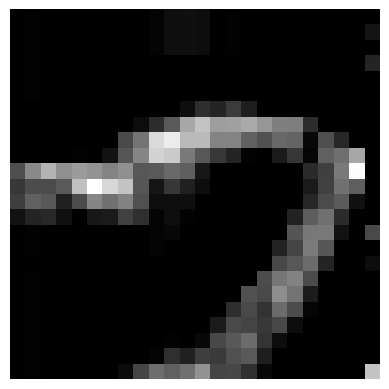

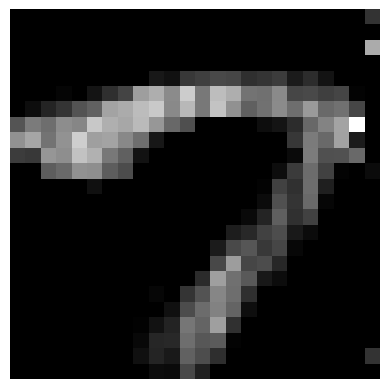

In [23]:
# print("layer weights", layer_weights)
# print("layer bias", layer_bias)
print("layer output", layer_output)
# print("fc weights", fc_weights)
# print("fc_bias", fc_bias)
plt.imshow(layer_output[:,:,1], cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()
plt.imshow(layer_output[:,:,0], cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
counter = 0
for i in range(1000):
    test = X_dev[:,:,i]
    label = Y_dev[i]
    # print(label)
    # plt.imshow(test, cmap='gray')
    # plt.axis('off')  # Turn off axis
    # plt.show()
    # print("Testing model:")
    _, _, _, final_output, _, _, _ = forward_propagation(
                    test, layer_weights, layer_bias, layer_output, fc_weights, fc_bias, gamma_conv, beta_conv, gamma_fc, beta_fc
                )
    # print("Model prediction: ")
    prediction = get_prediction(final_output)
    if (prediction == label):
        counter += 1
print(counter)